# Building model

In [1]:
from metaspace import SMInstance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepims_clust import DeepClustering
%load_ext autoreload
%autoreload 2

In [2]:
sm = SMInstance()

In [3]:
kidney_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s'
                  ]

In [4]:
kidney_results = {}
kidney_images = {}
kidney_if = {}
polarity = '+'

for k in kidney_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    kidney_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    kidney_images[k] = tmp
    kidney_if[k] = formula

100%|████████████████████████████████████████| 311/311 [00:01<00:00, 196.32it/s]                                        


## Image size adaption

In [5]:
def size_adaption(image_dict: dict):
    maxh = np.max([x.shape[1] for x in image_dict.values()])
    maxw = np.max([x.shape[2] for x in image_dict.values()])
    
    out_dict = {}
    for dsid, imgs in image_dict.items():
        # Height
        if imgs.shape[1] == maxh:
            pad1 = (0, 0)
        else:
            hdiff = maxh - imgs.shape[1]
            pad1 = (hdiff//2, hdiff//2 + hdiff%2)
        
        # Width
        if imgs.shape[2] == maxw:
            pad2 = (0, 0)
        else:
            wdiff = maxw - imgs.shape[2]
            pad2 = (wdiff//2, wdiff//2 + wdiff%2)

        out_dict[dsid] = np.pad(imgs, ((0, 0), pad1, pad2), constant_values=0)
    
    return out_dict

In [6]:
[x.shape for x in kidney_images.values()]

[(245, 74, 84), (221, 88, 88), (194, 41, 78), (237, 56, 85), (276, 71, 82)]

In [7]:
[x.shape for x in size_adaption(kidney_images).values()]

[(245, 88, 88), (221, 88, 88), (194, 88, 88), (237, 88, 88), (276, 88, 88)]

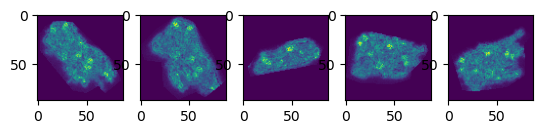

In [8]:
kidney_images_pad = size_adaption(kidney_images)
fig, axs = plt.subplots(ncols=len(kidney_images_pad))
for ax, im in zip(axs, kidney_images_pad):
    ax.imshow(kidney_images_pad[im][0, ::])
plt.show()

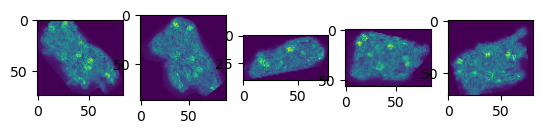

In [9]:
fig, axs = plt.subplots(ncols=len(kidney_images))
for ax, im in zip(axs, kidney_images):
    ax.imshow(kidney_images[im][0, ::])
plt.show()

## Ion overlap

In [10]:
tst = set(kidney_if['2022-12-07_02h13m50s']).intersection(set(kidney_if['2022-12-07_02h13m20s']), 
                                                          set(kidney_if['2022-12-07_02h10m45s']), 
                                                          set(kidney_if['2022-12-07_02h09m41s']), 
                                                          set(kidney_if['2022-12-07_02h08m52s']))

In [11]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 172


## Build data for training

Required: Dataset id for each image, ion id for each image

In [12]:
training_data = []
training_datasets = [] 
training_ions = []

kidney_images_pad = size_adaption(kidney_images)

for dsid, imgs in kidney_images_pad.items():
    
    training_data.append(imgs)
    training_datasets += [dsid] * imgs.shape[0]
    training_ions += kidney_if[dsid]
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

In [13]:
training_data.shape

(1173, 88, 88)

In [14]:
training_datasets.shape

(1173,)

In [15]:
training_ions.shape

(1173,)

## Training

In [17]:
model = DeepClustering(
                images=training_data,
                dataset_labels=training_datasets,
                ion_labels=training_ions,
                num_cluster=7,
                initial_upper=0.99,
                initial_lower=0.01,
                upper_iteration=2,
                lower_iteration=2,
                knn=False, k=10,
                lr=0.0001, batch_size=30,
                pretraining_epochs= 11,
                training_epochs=11,
                cae_encoder_dim=14,
                use_gpu=False
            )

In [ ]:
cae, clust = model.train()